In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !export PYTHONPATH=/Users/piyush/projects/ViDA-SSL/
import sys
sys.path.append("/Users/piyush/projects/ViDA-SSL/")

In [43]:
from os.path import join
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy.special import softmax

import torch
import torch.nn.functional as F
from fast_pytorch_kmeans import KMeans
from transformers import AutoTokenizer, AutoModel

from misc.local_utils import get_phrase_embedding, get_sentence_embedding, get_sent_emb_from_word_emb
from utils.viz import bokeh_2d_scatter, bokeh_2d_scatter_new
from datasets.ntu import NTU
from datasets.epic import EPIC
from datasets.something_something import SomethingSomething
from datasets.finegym import FineGym
from datasets.ucf import UCF
from datasets.kinetics import Kinetics

### Load datasets

In [5]:
datasets = [
    {
        "name": "Kinetics",
        "args": {"data_dir": "../../data/Kinetics-400/"},
        "color": "limegreen",
        "filename": "kinetics_400_labels.csv",
    },
    {
        "name": "UCF",
        "args": {"data_dir": "../../data/UCF-101/"},
        "color": "red",
        "filename": "classes_cleaned.txt",
    },
    {
        "name": "NTU",
        "args": {"data_dir": "../../data/NTU/"},
        "color": "blue",
        "filename": "class_labels.txt",
    },
    {
        "name": "SomethingSomething",
        "args": {"data_dir": "../../data/Something-Something/"},
        "color": "yellow",
        "filename": "fine_grained_classes_cleaned.csv",
    },
    {
        "name": "FineGym",
        "args": {"data_dir": "../../data/FineGym/"},
        "color": "gray",
        "filename": "gym99_categories_cleaned.txt",
    },
    {
        "name": "EPIC",
        "args": {"data_dir": "../../data/EPIC-KITCHENS-100/"},
        "color": "magenta",
        "filename": "EPIC_100_verb_classes.csv",
    },
]

In [6]:
# load class labels per dataset
dataset_action_labels = dict()

for dataset_args in datasets:
    dataset = eval(f"{dataset_args['name']}(**{dataset_args['args']})")
    class_label_dict = dataset._load_annotations(filename=dataset_args["filename"])
    dataset_action_labels[dataset_args['name']] = class_label_dict

### Get action class embeddings

In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

/Users/piyush/miniforge3/envs/video/lib/python3.9/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a Be

In [8]:
dataset_action_embeddings = dict()

for dataset, action_labels in dataset_action_labels.items():
    dataset_action_embeddings[dataset] = {
        # k: get_sentence_embedding(model, tokenizer, v) \
        # k: get_phrase_embedding(model, tokenizer, v) \
        k: get_sent_emb_from_word_emb(model, tokenizer, v)
        for k, v in tqdm(action_labels.items(), desc=f"Extracting BERT embeddings for {dataset}")
    }

Extracting BERT embeddings for NTU: 100%|███████████████████████████████████████████████| 120/120 [00:00<00:00, 17673.25it/s]
Extracting BERT embeddings for SomethingSomething: 100%|████████████████████████████████| 174/174 [00:00<00:00, 17138.91it/s]
Extracting BERT embeddings for EPIC: 100%|████████████████████████████████████████████████| 97/97 [00:00<00:00, 21588.00it/s]


### Visualize embeddings

In [9]:
dfs = []
all_embeddings = []

for datadict in datasets:
    local_df = pd.DataFrame(None)
    
    class_embeddings = dataset_action_embeddings[datadict["name"]]
    class_embeddings = torch.stack(list(class_embeddings.values()))
    action_labels = dataset_action_labels[datadict["name"]]
    
    local_df["class_id"] = list(action_labels.keys())
    local_df["class_label"] = list(action_labels.values())
    local_df["color"] = datadict["color"]
    local_df["dataset"] = datadict["name"]
    dfs.append(local_df)
    
    all_embeddings.append(class_embeddings)

In [10]:
embeddings = torch.cat(all_embeddings)
(U, S, V) = torch.pca_lowrank(embeddings)

K = 2

all_dimreds = []
for i, X in enumerate(all_embeddings):
    Z = torch.matmul(X, V[:, :K])
    
    try:
        dfs[i]["Z1"] = Z[:, 0]
        dfs[i]["Z2"] = Z[:, 1]
    except:
        import ipdb; ipdb.set_trace()

In [11]:
all_df = pd.concat(dfs)

In [12]:
all_df.head().shape

(5, 6)

In [13]:
all_df.head()

,class_id,class_label,color,dataset,Z1,Z2
0,0,abseiling,limegreen,Kinetics,0.240713,-0.000475
1,1,air drumming,limegreen,Kinetics,0.449278,0.082675
2,2,answering questions,limegreen,Kinetics,0.462436,0.084878
3,3,applauding,limegreen,Kinetics,0.381209,-0.071511
4,4,applying cream,limegreen,Kinetics,0.462518,0.046263


In [31]:
bokeh_2d_scatter_new(
    df=all_df, x="Z1", y="Z2", hue="dataset", label="class_label", use_nb=True, color_column="color",
    title="Word embeddings for action classes (phrases) in various datasets.", legend_loc="bottom_right",
)

Loading BokehJS ...

### Compute overlap for every `target` dataset w.r.t. `source` dataset

In [15]:
def compute_label_similarity(source: dict, target: dict, threshold: float = 0.1):
    df = pd.DataFrame(None, index=list(source.keys()), columns=list(target.keys()), dtype=float)

    source_embeddings = torch.stack([v for k, v in source.items()])
    target_embeddings = torch.stack([v for k, v in target.items()])
    
    for i in range(len(source_embeddings)):
        df.iloc[i] = F.cosine_similarity(target_embeddings, source_embeddings[[i], :]).numpy()
    
    return df

In [64]:
dataset_action_embeddings["UCF"]["1"].shape

torch.Size([768])

In [16]:
dataset_action_embeddings.keys()

dict_keys(['Kinetics', 'UCF', 'NTU', 'SomethingSomething', 'FineGym', 'EPIC'])

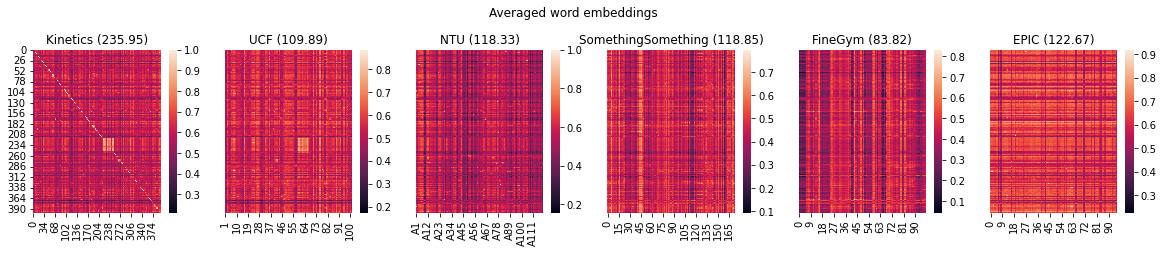

In [70]:
dataset_label_overlap = pd.DataFrame(None, index=["Kinetics"], columns=dataset_action_embeddings.keys())

fig, axes = plt.subplots(1, len(dataset_action_embeddings), figsize=(20, 3))

i = 0
for key in dataset_action_embeddings:
    df = compute_label_similarity(dataset_action_embeddings["Kinetics"], dataset_action_embeddings[key])
    # df.iloc[:, :] = softmax(df.values, axis=0)
    # df.iloc[:, :] = np.divide(df.values, df.values.sum(axis=0))
    # df = df/df.sum(axis=0)

    # overlap = np.linalg.norm(df.values) / df.shape[0]
    # import ipdb; ipdb.set_trace()
    overlap = np.linalg.norm(df.values)
    dataset_label_overlap.loc["Kinetics", key] = overlap

    ax = axes[i]
    sns.heatmap(df, ax=ax)
    ax.set_title(f"{key} ({overlap:.2f})")
    
    if i > 0:
        ax.set_yticks([])
    i += 1
    
    df = df.rename(columns=dataset_action_labels[key], index=dataset_action_labels["Kinetics"])

plt.suptitle("Averaged word embeddings", y=1.08)
plt.show()

In [55]:
dataset_label_overlap

,Kinetics,UCF,NTU,SomethingSomething,FineGym,EPIC
Kinetics,1.005774,0.504555,0.550863,0.663512,0.50216,0.494952


In [57]:
df.max(0)

take        0.003087
put         0.003559
wash        0.003132
open        0.003162
close       0.003122
              ...   
prepare     0.003044
bake        0.002969
mark        0.003091
bend        0.003189
unfreeze    0.003146
Length: 97, dtype: float64